# Import module and Read data

In [ ]:
!pip install geopy


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from geopy.geocoders import Nominatim

pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('/work/data/landslide/GLC_features.csv') 
df.head(5)

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,soil_texture_10,soil_texture_30,soil_texture_60,soil_texture_100,soil_texture_200,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
0,AGU,https://blogs.agu.org/landslideblog/2008/10/14...,684,08/01/2008 12:00:00 AM,NaN,"Sigou Village, Loufan County, Shanxi Province","occurred early in morning, 11 villagers buried...","Sigou Village, Loufan County, Shanxi Province",unknown,landslide,...,Lo,Lo,Lo,ClLo,ClLo,10.897663,10.860593,10.777864,10.649446,10.416670
1,Oregonian,http://www.oregonlive.com/news/index.ssf/2009/...,956,01/02/2009 02:00:00 AM,NaN,"Lake Oswego, Oregon",Hours of heavy rain are to blame for an overni...,"Lake Oswego, Oregon",5km,mudslide,...,Lo,Lo,Lo,Lo,Lo,1709.162231,1803.502075,1896.032104,1971.151001,2037.960693
2,CBS News,https://www.cbsnews.com/news/dozens-missing-af...,973,01/19/2007 12:00:00 AM,NaN,"San Ramon district, 195 miles northeast of the...",(CBS/AP) At least 10 people died and as many a...,"San Ramon district, 195 miles northeast of the...",10km,landslide,...,ClLo,ClLo,ClLo,ClLo,ClLo,40.594688,42.369690,43.759224,44.929241,45.351627
3,Reuters,https://in.reuters.com/article/idINIndia-41450...,1067,07/31/2009 12:00:00 AM,NaN,Dailekh district,"One person was killed in Dailekh district, pol...",Dailekh district,unknown,landslide,...,Lo,Lo,ClLo,ClLo,ClLo,67.572578,77.243866,80.174164,76.922607,65.961479
4,The Freeman,http://www.philstar.com/cebu-news/621414/lands...,2603,10/16/2010 12:00:00 PM,NaN,sitio Bakilid in barangay Lahug,Another landslide in sitio Bakilid in barangay...,sitio Bakilid in barangay Lahug,5km,landslide,...,ClLo,ClLo,ClLo,ClLo,ClLo,4523.530762,5415.132812,6229.119141,7087.629883,7936.315918


# Info

**Nhận xét:**
*  Tất cả các thuộc tính đã đúng kiểu dữ liệu
* 'location_accuracy' : format lại về int64, hoặc giữ nguyên là 1 biến phân loại
* 'loss', 'gain'      : cái int64, cái float64 -> it's not a big deal
*  Các thuộc tính là datetime cần format lại


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11033 entries, 0 to 11032
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   source_name                11033 non-null  object 
 1   source_link                10187 non-null  object 
 2   event_id                   11033 non-null  int64  
 3   event_date                 11033 non-null  object 
 4   event_time                 0 non-null      float64
 5   event_title                11033 non-null  object 
 6   event_description          10171 non-null  object 
 7   location_description       10931 non-null  object 
 8   location_accuracy          11031 non-null  object 
 9   landslide_category         11032 non-null  object 
 10  landslide_trigger          11010 non-null  object 
 11  landslide_size             11024 non-null  object 
 12  landslide_setting          10964 non-null  object 
 13  fatality_count             9648 non-null   flo

In [5]:
# Chia thành 2 nhóm: các thuộc tính định lượng và thuộc tính phân loại
df_quan = df.select_dtypes(exclude='object')
quan_cols = df_quan.columns
cate_cols = df.columns.difference(quan_cols)
df_cate = df.loc[:, cate_cols]

print("Quantitative columns' name:\n", quan_cols, quan_cols.shape[0])
print("\nCategorical columns' name:\n", cate_cols, cate_cols.shape[0])


Quantitative columns' name:
 Index(['event_id', 'event_time', 'fatality_count', 'injury_count',
       'event_import_id', 'admin_division_population', 'gazeteer_distance',
       'longitude', 'latitude', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover',
       'windgust', 'windspeed', 'winddir', 'pressure', 'cloudcover',
       'visibility', 'moonphase', 'elevation', 'treecover2000', 'loss', 'gain',
       'population_density_2000', 'population_density_2005',
       'population_density_2010', 'population_density_2015',
       'population_density_2020'],
      dtype='object') 35

Categorical columns' name:
 Index(['admin_division_name', 'conditions', 'continent', 'country_code',
       'country_name', 'created_date', 'event_date', 'event_description',
       'event_import_source', 'event_title', 'gazeteer_closest_point',
       'landslide_category', 'landslide_setting', 'landslide_size',
       'landslide_trigge

**Tỉ lệ giá trị bị khuyết**

In [6]:
sum_null = df.isnull().sum().sum()
rate_null = sum_null/(df.shape[0]*df.shape[1])*100
print('Tỉ lệ dữ liệu bị khuyết giá trị: %.2f'%(rate_null),'%')
df.isnull().sum().sort_values(ascending=False).to_frame()

Tỉ lệ dữ liệu bị khuyết giá trị: 12.18 %


,0
event_time,11033
notes,10716
storm_name,10456
photo_link,9537
windgust,7207
...,...
treecover2000,0
season,0
continent,0
elevation,0


# 1. Preprocessing Country Name and Datetime

**country_name**

Format lại tên quốc gia cũng như xử lý tên quốc gia bị thiếu dựa trên toạ độ. Sử dụng Nominatim của geopy

In [ ]:
m_c_index = df[df['country_name'].isnull()==True].index

geolocator = Nominatim(user_agent="geoapiExercises",timeout=None)

for i in m_c_index:
  Latitude = df.loc[i,'latitude']
  Longitude = df.loc[i,'longitude']
  location = geolocator.reverse(str(Latitude)+","+str(Longitude),language='en')
  address = location.raw['address']
  df.at[i,'country_name']=address['country']

df = df.replace({'country_name':{'Myanmar [Burma]':'Myanmar',
                                 'U.S. Virgin Islands':'United States Virgin Islands'}})

In [7]:
df['country_name'].isnull().sum()

0

**datatime**

format lại các thuộc tính là datetime:
* event_date
* created_date
* last_edited_date
* submitted_date
* event_time

In [8]:
df['event_date'] = pd.to_datetime(df['event_date'],format='%m/%d/%Y %I:%M:%S %p',dayfirst=True)
df['created_date'] = pd.to_datetime(df['created_date'],format='%m/%d/%Y %I:%M:%S %p',dayfirst=True)
df['last_edited_date'] = pd.to_datetime(df['last_edited_date'],format='%m/%d/%Y %I:%M:%S %p',dayfirst=True)
df['submitted_date'] = pd.to_datetime(df['submitted_date'],format='%m/%d/%Y %I:%M:%S %p',dayfirst=True)

df['event_time'] = df['event_date'].dt.time

# 2. Cut down unnecessary attributes

In [9]:
df['event_import_source'].value_counts()

glc                                                                                 9379
test                                                                                  90
Included as a subset of an article, more information may be found somewhere else       1
Name: event_import_source, dtype: int64

Lí do bỏ các thuộc tính
* 'source_link' (2), 'photo_link' (17)	                                : Vì là liên kết trang web
* 'event_id' (3), 'event_import_id' (20)	                            : Vì là mã định danh
* 'submitted_date' (27), 'created_date' (29), 'last_edited_date' (29)	: Chỉ chứa các thông tin tracking sample trên dataset
* 'source_name' (1), 'storm_name' (16), 'notes' (18), 	                : Số lượng sample là null trên 90%
* 'event_time' (5)	                                                    : Trong thuộc tính ‘event_date’ đã chứa thông tin thời gian
* 'event_import_source' (19) 	                                        : Chứa những thông tin không quan trọng.
* 'latitude','longitude': gộp thành geolocation


In [10]:
df.drop([
  'event_time', 'source_name',
  'source_link', 'event_id', 'photo_link', 'notes', 
  'event_import_source', 'event_import_id', 'country_code', 
  'submitted_date', 'created_date', 'last_edited_date', 
  'storm_name'
  
],axis=1, inplace=True) 


# 3. Handle missing values

## Bộ gốc

### text

**event_description**

Just leave them empty


In [11]:
df['event_description']

0        occurred early in morning, 11 villagers buried...
1        Hours of heavy rain are to blame for an overni...
2        (CBS/AP) At least 10 people died and as many a...
3        One person was killed in Dailekh district, pol...
4        Another landslide in sitio Bakilid in barangay...
                               ...                        
11028    Landslide exacerbated by deforestation and bad...
11029    Two teenage girls died after they were buried ...
11030    An octogenarian was killed when a sudden lands...
11031    Landslide triggered by heavy rainfall buried 1...
11032    A mudslide at an under-construction commercial...
Name: event_description, Length: 11033, dtype: object

In [12]:
df['event_description'].fillna(value='', inplace=True)

**admin_division_name**

Thay thế tên đơn vị hành chính bị thiếu bằng tên quốc gia

In [13]:
df['admin_division_name'].mask(df['admin_division_name'].isnull(), df['country_name'], inplace=True)

**location_description**

Thay thế location_description bị thiếu bằng tên đơn vị hành chính và tên quốc gia. Nếu tên đơn vị hành chính trùng tên quốc gia thì chỉ lấy tên quốc gia

In [14]:
df['location_description']

0            Sigou Village, Loufan County, Shanxi Province
1                                      Lake Oswego, Oregon
2        San Ramon district, 195 miles northeast of the...
3                                         Dailekh district
4                          sitio Bakilid in barangay Lahug
                               ...                        
11028             Banaran, Ponorogo, Jawa Timur, Indonesia
11029    Barnari Sigdi area, Tehsil Mughalmaidan, Kisht...
11030             Pub Sarania Hill, Guwahati, Assam, India
11031                          Ayu, Ozgon, Osh, Kyrgyzstan
11032                     Hyderabad, Rangareddy, Telangana
Name: location_description, Length: 11033, dtype: object

In [15]:
# ghép tên đvhc và tên quốc gia
address = np.where(
    df['admin_division_name']==df['country_name'],                     # if
    df['country_name'],                                                # then
    df[['admin_division_name', 'country_name']].agg(', '.join, axis=1) # else
)
address

array(['Shaanxi, China', 'Oregon, United States', 'Junín, Peru', ...,
       'India', 'Kyrgyzstan', 'India'], dtype=object)

In [16]:
# thay thế giá trị bị thiếu với địa chỉ tương ứng
df['location_description'].mask(df['location_description'].isnull(), address, inplace=True)

### gazeteer

**gazeteer_closest_point & gazeteer_distance**

'gazeteer_closest_point' là địa điểm gần nơi xảy ra sạt lở, điền địa điểm bị thiếu bằng tên đơn vị hành chính, đồng thời cho 'gazeteer_distance' (khoảng cách từ địa điểm này tới nơi sạt lở (tính bằng km)) giá trị 0.1 km

In [17]:
df.loc[df['gazeteer_closest_point'].isnull()].loc[:, ['gazeteer_closest_point', 'gazeteer_distance']]

,gazeteer_closest_point,gazeteer_distance
13,NaN,NaN
42,NaN,NaN
53,NaN,NaN
73,NaN,NaN
77,NaN,NaN
...,...,...
11028,NaN,NaN
11029,NaN,NaN
11030,NaN,NaN
11031,NaN,NaN


In [18]:
df['gazeteer_closest_point'].mask(df['gazeteer_closest_point'].isnull(), df['admin_division_name'], inplace=True)

In [19]:
df['gazeteer_distance'].fillna(value=0.10001, inplace=True)

### population

**population_density**
* population_density_2000
* population_density_2005
* population_density_2010
* population_density_2015
* population_density_2020

Thay thế mật độ dân số bị thiếu (các năm) với giá trị 0

In [20]:
df['population_density_2000'].fillna(value=0, inplace=True)
df['population_density_2005'].fillna(value=0, inplace=True)
df['population_density_2010'].fillna(value=0, inplace=True)
df['population_density_2015'].fillna(value=0, inplace=True)
df['population_density_2020'].fillna(value=0, inplace=True)

**'admin_division_population' using KNNImputer** 
* Dân số đơn vị hành chính có tương quan moderate (~0.50) với mật độ dân số qua các năm
* Sử dụng KNNImputer điền missing values tại 'admin_division_population'

In [21]:
# tạo df cho các thuộc tính 
df_popu = df[['admin_division_population', 'population_density_2000', 'population_density_2005', 
                'population_density_2010', 'population_density_2015', 'population_density_2020']]

In [22]:
# kiểm tra có bao nhiêu dòng có missing
missing_admin_popu_index = df_popu.loc[df_popu['admin_division_population'].isnull()].index # lưu index những dòng có missing 
df_popu.loc[df_popu['admin_division_population'].isnull()]


,admin_division_population,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
13,NaN,105.034233,115.145462,125.287666,136.355957,146.274628
42,NaN,201.934677,197.529739,192.508438,185.529144,177.818222
53,NaN,85.997246,94.275864,102.579834,111.642052,119.763008
73,NaN,280.166504,293.580505,309.162537,318.761688,315.732849
77,NaN,246.620331,254.967926,262.626129,267.507172,270.978424
...,...,...,...,...,...,...
11028,NaN,604.195312,604.763977,601.238159,593.050171,574.945679
11029,NaN,28.511465,31.421850,34.245689,36.899521,39.488865
11030,NaN,761.167053,830.007263,895.046692,954.223511,1010.400879
11031,NaN,74.432564,77.241089,82.914101,90.541176,97.722855


In [23]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=40) # n_neighbors=sqrt(1562)
arr_popu_preprocessed = imputer.fit_transform(df_popu)

In [24]:
# lưu vào 1 df rồi loc xem tại những admin_division_population là missing value trước đó giờ đã đc fill ntn 
df_popu_preprocessed = pd.DataFrame(arr_popu_preprocessed, columns=df_popu.columns)
df_popu_preprocessed.loc[missing_admin_popu_index]

,admin_division_population,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
13,42748.500,105.034233,115.145462,125.287666,136.355957,146.274628
42,33369.400,201.934677,197.529739,192.508438,185.529144,177.818222
53,13997.075,85.997246,94.275864,102.579834,111.642052,119.763008
73,58996.925,280.166504,293.580505,309.162537,318.761688,315.732849
77,17853.375,246.620331,254.967926,262.626129,267.507172,270.978424
...,...,...,...,...,...,...
11028,324195.825,604.195312,604.763977,601.238159,593.050171,574.945679
11029,11107.850,28.511465,31.421850,34.245689,36.899521,39.488865
11030,282501.425,761.167053,830.007263,895.046692,954.223511,1010.400879
11031,13037.500,74.432564,77.241089,82.914101,90.541176,97.722855


In [25]:
# chính thức lưu admin_division_population đã xử lý missing values sử dụng KNNimputer
arr_popu_preprocessed = arr_popu_preprocessed.astype(int)
df['admin_division_population'] = arr_popu_preprocessed

### others

**số lượng thương-tử vong, dân số địa phương**
* 'fatality_count'
* 'injury_count'
* 'admin_division_population'
thay thế missing values bằng giá trị median (ko dùng mean vì số người tính số nguyên, ko dùng mode vì có outlier)

In [26]:
print(df['fatality_count'].mode())
print(df['injury_count'].mode())
print(df['admin_division_population'].mode())
print(df['fatality_count'].median())
print(df['injury_count'].median())
print(df['admin_division_population'].median())

0    0.0
dtype: float64
0    0.0
dtype: float64
0    0
dtype: int64
0.0
0.0
9614.0


In [27]:
df['fatality_count'].fillna((df['fatality_count'].median()), inplace=True)
df['injury_count'].fillna((df['injury_count'].median()), inplace=True)

**location_accuracy**

Đưa các missing values về giá trị unknown

In [28]:
df['location_accuracy'].replace(to_replace=np.nan, value='unknown', inplace=True)

In [29]:
df['location_accuracy'].value_counts()

5km        3178
1km        2185
25km       1470
10km       1435
exact      1386
50km        794
unknown     544
100km        25
250km        16
Name: location_accuracy, dtype: int64

**landslide_category**

In [31]:
df.dropna(subset=['landslide_category'],axis=0, inplace=True)

**landslide_setting**

In [34]:
df.dropna(subset=['landslide_setting'],axis=0, inplace=True)

**landslide_trigger**

In [36]:
df.dropna(subset=['landslide_trigger'],axis=0, inplace=True)

**landslide_size**

In [38]:
df.dropna(subset=['landslide_size'],axis=0, inplace=True)

## Weather and others

**stations**

In [40]:
df.dropna(subset=['stations'],axis=0, inplace=True)

**temperature**

Loại bỏ các dòng khi giá trị ở 'temp' 'tempmax', 'tempmin', 'feelikes', 'feelslikemax', 'feelslikemin' là nan

Lưu ý: Khi 1 sample bị thiếu giá trị ở 1 thuộc tính ('temp') thì giá trị của sample đó ở 1 số thuộc tính còn lại ('feelslike',...) cũng bị thiếu giá trị

In [41]:
df[df['temp'].isnull()].loc[:, 'tempmax':]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipcover,...,soil_texture_10,soil_texture_30,soil_texture_60,soil_texture_100,soil_texture_200,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ClLo,ClLo,ClLo,ClLo,ClLo,53.002323,58.648575,64.177368,69.429977,74.602135
743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ClLo,ClLo,ClLo,ClLo,ClLo,3132.522705,3133.400635,3105.743652,3041.066895,2957.929688
777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SaLo,SaClLo,SaLo,SaLo,SaLo,97.120041,113.044777,129.978088,147.754852,165.473267
1141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Lo,Lo,ClLo,Lo,Lo,53.547459,58.702660,58.432392,53.764870,44.214062
1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ClLo,ClLo,ClLo,ClLo,ClLo,3360.846191,3397.244873,3408.400635,3420.414307,3383.263672
1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ClLo,ClLo,ClLo,ClLo,ClLo,120.439430,130.724670,141.118973,153.910583,167.753571
2067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ClLo,ClLo,ClLo,ClLo,ClLo,35.553513,34.038864,32.036392,29.591476,26.767763
2420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ClLo,ClLo,ClLo,ClLo,ClLo,216.223358,226.085236,214.644012,188.371201,147.749832
3602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Lo,ClLo,ClLo,ClLo,ClLo,187.802017,201.648590,196.592545,177.169128,142.700607
3913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Lo,Lo,Lo,Lo,Lo,124.890732,131.710205,137.363220,141.632278,145.041779


In [42]:
df.dropna(subset=['temp'],axis=0, inplace=True)

In [43]:
df[df['feelslike'].isnull()].iloc[:, 20:]

,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipcover,windgust,windspeed,...,soil_texture_10,soil_texture_30,soil_texture_60,soil_texture_100,soil_texture_200,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
5903,22.3,NaN,NaN,NaN,9.3,44.94,0.40,8.33,53.6,24.2,...,Lo,Lo,SaLo,SaLo,SaLo,0.000000,0.000000,0.000000,0.000000,0.000000
8476,25.8,NaN,NaN,NaN,175.5,79.78,23.38,46.15,NaN,18.4,...,ClLo,ClLo,Cl,ClLo,ClLo,556.338867,583.376343,607.589661,627.850342,637.664795
10820,25.9,NaN,NaN,NaN,9.3,38.89,0.00,0.00,NaN,21.6,...,Lo,Lo,Lo,Lo,Lo,12.613620,13.190482,13.947905,14.790569,15.547897


In [44]:
df.dropna(subset=['feelslike'],axis=0, inplace=True)

**dew & humidity**

In [45]:
df[df['dew'].isnull()].loc[:, 'dew':]

,dew,humidity,precip,precipcover,windgust,windspeed,winddir,pressure,cloudcover,visibility,...,soil_texture_10,soil_texture_30,soil_texture_60,soil_texture_100,soil_texture_200,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
46,NaN,NaN,0.0,0.00,NaN,9.4,94.0,NaN,96.7,6.3,...,Lo,Lo,Lo,Lo,SaLo,25.455221,27.371544,26.723829,24.118328,19.454163
616,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,0.0,NaN,...,Lo,Lo,Lo,Lo,Lo,0.001665,0.001607,0.001545,0.001469,0.001389
690,NaN,NaN,0.0,0.00,NaN,11.2,110.0,NaN,59.6,9.1,...,Lo,ClLo,ClLo,ClLo,ClLo,222.636841,239.397415,233.732391,210.944107,170.150299
1182,NaN,NaN,0.0,0.00,NaN,22.3,133.0,NaN,56.7,10.3,...,Lo,Lo,Lo,Lo,SaLo,13.296986,13.983135,14.468013,14.785733,14.845430
1239,NaN,NaN,0.0,0.00,NaN,9.4,150.0,NaN,76.2,8.5,...,Lo,Lo,Lo,Lo,Lo,104.990005,112.893883,110.222389,99.476006,80.238655
2092,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,0.0,NaN,...,SaLo,SaLo,SaLo,SaLo,SaLo,0.650572,0.679226,0.706528,0.726757,0.743448
2181,NaN,NaN,0.0,0.00,NaN,18.4,177.1,NaN,55.6,9.5,...,ClLo,ClLo,ClLo,ClLo,ClLo,191.845688,202.629669,194.326035,172.269348,136.490326
2271,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,0.0,NaN,...,Lo,Lo,Lo,Lo,Lo,0.131430,0.126819,0.121918,0.115904,0.109580
2816,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,0.0,NaN,...,Lo,Lo,Lo,Lo,SaClLo,0.033498,0.033333,0.033047,0.032398,0.031588
3727,NaN,NaN,0.0,0.00,NaN,13.0,75.2,1001.6,76.0,7.5,...,Lo,ClLo,ClLo,ClLo,Lo,169.285553,178.798340,171.468460,152.003754,120.431862


In [46]:
df.dropna(subset=['dew'],axis=0, inplace=True)

In [47]:
print(df[['dew', 'humidity']].isnull().sum())

dew         0
humidity    0
dtype: int64


**wind, pressure**
* windgust
* windspeed
* winddir
* pressure
* visibility

Xem phân bố giá trị để chọn mean/mode/median phù hợp cho giá trị bị thiếu. Với thuộc tính nào có nhiều outliers thì nên chọn median.

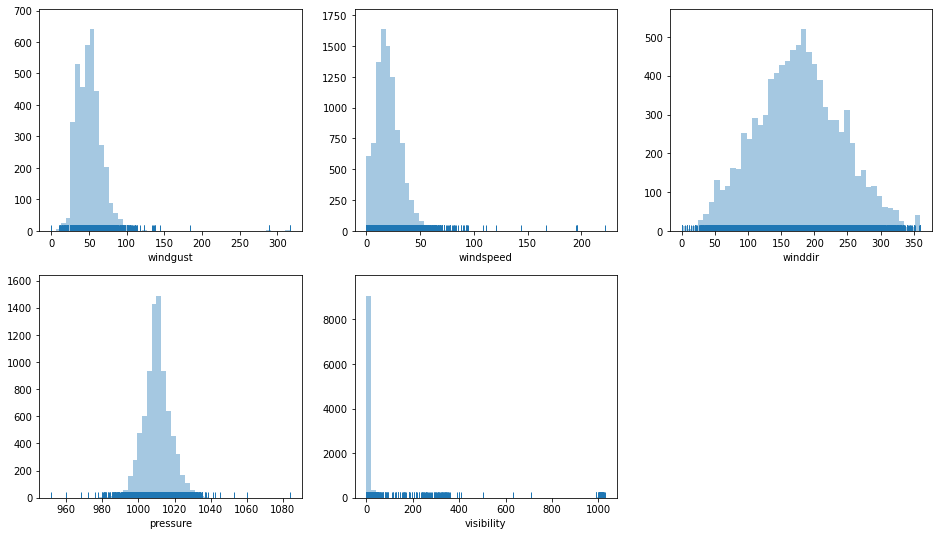

In [48]:
wind_and_friends = ['windgust', 'windspeed', 'winddir', 'pressure','visibility']
fig = plt.figure(figsize=(16,9))
for i in range(len(wind_and_friends)):
    ax = plt.subplot(2, 3, i+1)
    sns.distplot(df[wind_and_friends[i]], kde=False, rug=True, ax=ax)

In [49]:
for colname in wind_and_friends:
    print(colname)
    print('mean:', df[colname].mean())
    print('median:', df[colname].median())
    print('mode:', df[colname].mode())
    print()

windgust
mean: 50.95586533403471
median: 50.0
mode: 0    55.4
dtype: float64

windspeed
mean: 20.90724202237878
median: 18.4
mode: 0    18.4
dtype: float64

winddir
mean: 176.5636135644968
median: 176.0
mode: 0    180.0
dtype: float64

pressure
mean: 1010.1829510981677
median: 1010.1
mode: 0    1010.0
dtype: float64

visibility
mean: 18.29172830503177
median: 10.8
mode: 0    16.0
dtype: float64



In [50]:
df['windgust'].fillna(value=df['windgust'].mean(), inplace=True)
df['windspeed'].fillna(value=df['windspeed'].mean(), inplace=True)
df['winddir'].fillna(value=df['winddir'].mean(), inplace=True)
df['pressure'].fillna(value=df['pressure'].mean(), inplace=True)
df['visibility'].fillna(value=df['visibility'].median(), inplace=True)

**treecover**
* loss: Sự thay đổi từ forest sang non-forest (value: 0 or 1) -> điền gt bị thiếu là mode



In [51]:
df['loss'].fillna(df['loss'].mode()[0],inplace=True) # loss.mode() = 0

**soil_texture**
* soil_texture_0
* soil_texture_10
* soil_texture_30
* soil_texture_60
* soil_texture_100
* soil_texture_200

Loại bỏ các dòng khi giá trị ở 'soil_texture_0', 'soil_texture_10'....   là nan

Lưu ý: Khi 1 sample bị thiếu giá trị ở 1 thuộc tính thì giá trị của sample đó ở 1 số thuộc tính còn lại cũng bị thiếu giá trị. Do đó chọn phương án loại bỏ sample đó

In [52]:
df[df['soil_texture_0'].isnull()].loc[:, 'soil_texture_0':]

,soil_texture_0,soil_texture_10,soil_texture_30,soil_texture_60,soil_texture_100,soil_texture_200,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
17,NaN,NaN,NaN,NaN,NaN,NaN,3.931448,4.131183,4.325059,4.477697,4.610194
56,NaN,NaN,NaN,NaN,NaN,NaN,4498.347656,5429.791992,6420.830078,7514.256836,8699.527344
328,NaN,NaN,NaN,NaN,NaN,NaN,113.848228,118.211563,121.825752,125.580612,127.595444
338,NaN,NaN,NaN,NaN,NaN,NaN,330.663940,335.694946,346.828278,354.718170,362.091858
397,NaN,NaN,NaN,NaN,NaN,NaN,1086.985107,1045.984741,1001.471924,951.931946,900.883118
...,...,...,...,...,...,...,...,...,...,...,...
10878,NaN,NaN,NaN,NaN,NaN,NaN,149.250122,153.071472,159.766418,165.072998,170.228760
10919,NaN,NaN,NaN,NaN,NaN,NaN,360.058502,391.049652,423.142212,452.778687,481.822754
10932,NaN,NaN,NaN,NaN,NaN,NaN,4.548400,4.557880,4.589313,4.589913,4.550186
10970,NaN,NaN,NaN,NaN,NaN,NaN,2484.133301,2473.468262,2452.430908,2421.042480,2366.004395


In [53]:
df.dropna(subset=['soil_texture_0'], axis=0, inplace=True)

## read csv

In [54]:
# **lưu vào 1 df**
df_preprocessed_missing = df.copy()
df_preprocessed_missing.shape

(9345, 54)

In [55]:
# only preprocessed missing
df_preprocessed_missing.to_csv('/work/data/landslide/GLC_features_preprocessed.csv',index=False)

# 4. Handle outliers (archived)

## Draft

In [56]:
df.fatality_count.sort_values(ascending=False).values

array([1765.,  491.,  430., ...,    0.,    0.,    0.])

In [57]:
df.loc[df['fatality_count']==1765, :] # admin_division_population = 0

,event_date,event_title,event_description,location_description,location_accuracy,landslide_category,landslide_trigger,landslide_size,landslide_setting,fatality_count,...,soil_texture_10,soil_texture_30,soil_texture_60,soil_texture_100,soil_texture_200,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
8173,2010-08-07 23:00:00,"Zhugqu urban center and Beijie village, Bailon...",In China rescuers used shovels and bare hands ...,"Zhugqu urban center and Beijie village, Bailon...",5km,landslide,downpour,very_large,unknown,1765.0,...,Lo,Lo,Lo,Lo,Lo,309.480194,319.779419,329.023743,337.069244,341.836548


In [58]:
df.injury_count.sort_values(ascending=False).values

array([374., 332., 100., ...,   0.,   0.,   0.])

**IQR** (mất mát dữ liệu nhiều -> ko chọn xử lý outliers theo IQR)

In [59]:
outlier_col = ['temp', 'tempmax', 'tempmin', 'feelslike', 'feelslikemax', 
            'feelslikemin', 'dew', 'windgust', 'windspeed', 'pressure', 'visibility']
df_outlier = df.loc[:, outlier_col]

In [60]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
df_out_IQR = df_outlier[~((df_outlier < (Q1 - 1.5 * IQR)) |(df_outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out_IQR.shape # mất mát nhiều


(5157, 11)

## Handle outliers

In [61]:
outlier_col = ['temp', 'tempmax', 'tempmin', 'feelslike', 'feelslikemax', 
            'feelslikemin', 'dew', 'windgust', 'windspeed', 'pressure', 'visibility']


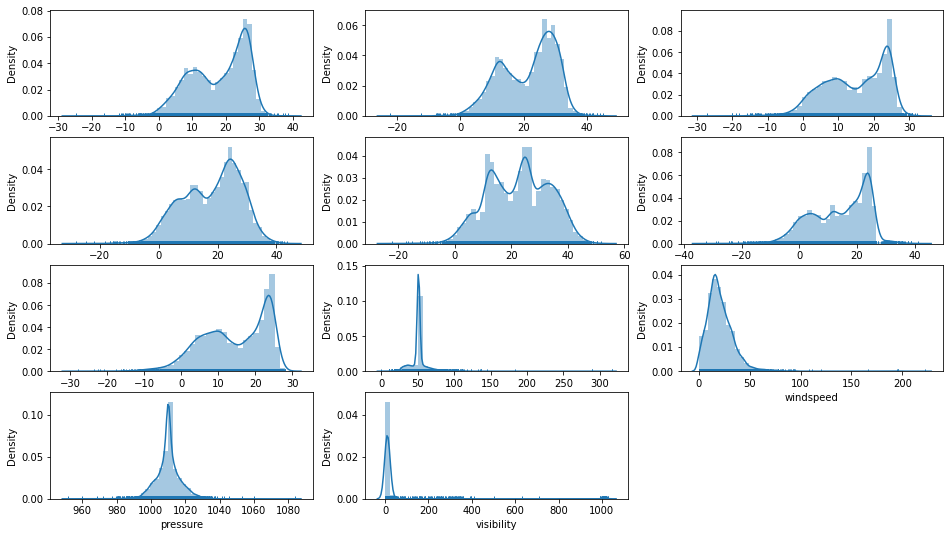

In [62]:
fig = plt.figure(figsize=(16,9))
for i in range(len(outlier_col)):
    ax = plt.subplot(4, 3, i+1)
    sns.distplot(df[outlier_col[i]], kde=True, rug=True, ax=ax)

In [63]:
df.drop(df[df['fatality_count']==1765].index, inplace=True)
df.drop(df[df['injury_count']==374].index, inplace=True)
df.drop(df[df['injury_count']==332].index, inplace=True)

In [64]:
# lựa chọn những thuộc tính có outliers (nhìn boxplot or scatterplot theo landslide_size và landslide_trigger)
outlier_col = ['temp', 'tempmax', 'tempmin', 'feelslike', 'feelslikemax', 
            'feelslikemin', 'dew', 'windgust', 'windspeed', 'pressure', 'visibility']
df_outlier = df.loc[:, outlier_col]

In [65]:
z = np.abs(stats.zscore(df_outlier))
#print(z)
threshold = 3
over_threshold = np.where(z>3)
# pd.DataFrame(over_threshold, index=['row', 'col'])
df_preprocessed = df[(z < 3).all(axis=1)]
df_preprocessed.shape

(8938, 54)

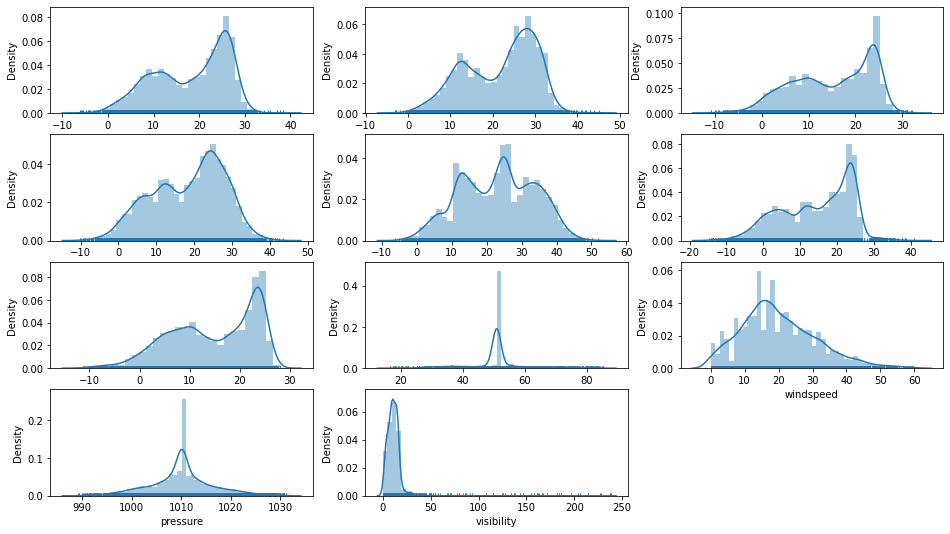

In [66]:
fig = plt.figure(figsize=(16,9))
for i in range(len(outlier_col)):
    ax = plt.subplot(4, 3, i+1)
    sns.distplot(df_preprocessed[outlier_col[i]], kde=True, rug=True, ax=ax)

## read csv

In [67]:
df_preprocessed.shape

(8938, 54)

In [68]:
# # preprocessed missing + outliers
# df_preprocessed.to_csv('/work/data/landslide/GLC_features_preprocessed_outliers.csv',index=False)

# Tracking

## missing values

In [70]:
sum_null = df_preprocessed_missing.isnull().sum().sum()
rate_null = sum_null/df_preprocessed_missing.size*100

print('Data shape ban đầu: (11033, 67)')
print('Data shape sau khi tiền xử lý:', df_preprocessed_missing.shape)
print('Tỉ lệ kích thước data sau txl so với ban đầu: %.2f' %(df_preprocessed_missing.size/(11033*67)*100), '%')
print('Tổng số giá trị bị khuyết:', sum_null)
print('Tỉ lệ dữ liệu bị khuyết giá trị: %.2f'%(rate_null),'%')


Data shape ban đầu: (11033, 67)
Data shape sau khi tiền xử lý: (9345, 54)
Tỉ lệ kích thước data sau txl so với ban đầu: 68.27 %
Tổng số giá trị bị khuyết: 0
Tỉ lệ dữ liệu bị khuyết giá trị: 0.00 %


## missing + outliers (archived)

In [71]:
sum_null = df_preprocessed.isnull().sum().sum()
rate_null = sum_null/df_preprocessed.size*100

print('Data shape ban đầu: (11033, 67)')
print('Data shape sau khi tiền xử lý:', df_preprocessed.shape)
print('Tỉ lệ kích thước data sau txl so với ban đầu: %.2f' %(df_preprocessed.size/(11033*67)*100), '%')
print('Tổng số giá trị bị khuyết:', sum_null)
print('Tỉ lệ dữ liệu bị khuyết giá trị: %.2f'%(rate_null),'%')

Data shape ban đầu: (11033, 67)
Data shape sau khi tiền xử lý: (8938, 54)
Tỉ lệ kích thước data sau txl so với ban đầu: 65.29 %
Tổng số giá trị bị khuyết: 0
Tỉ lệ dữ liệu bị khuyết giá trị: 0.00 %


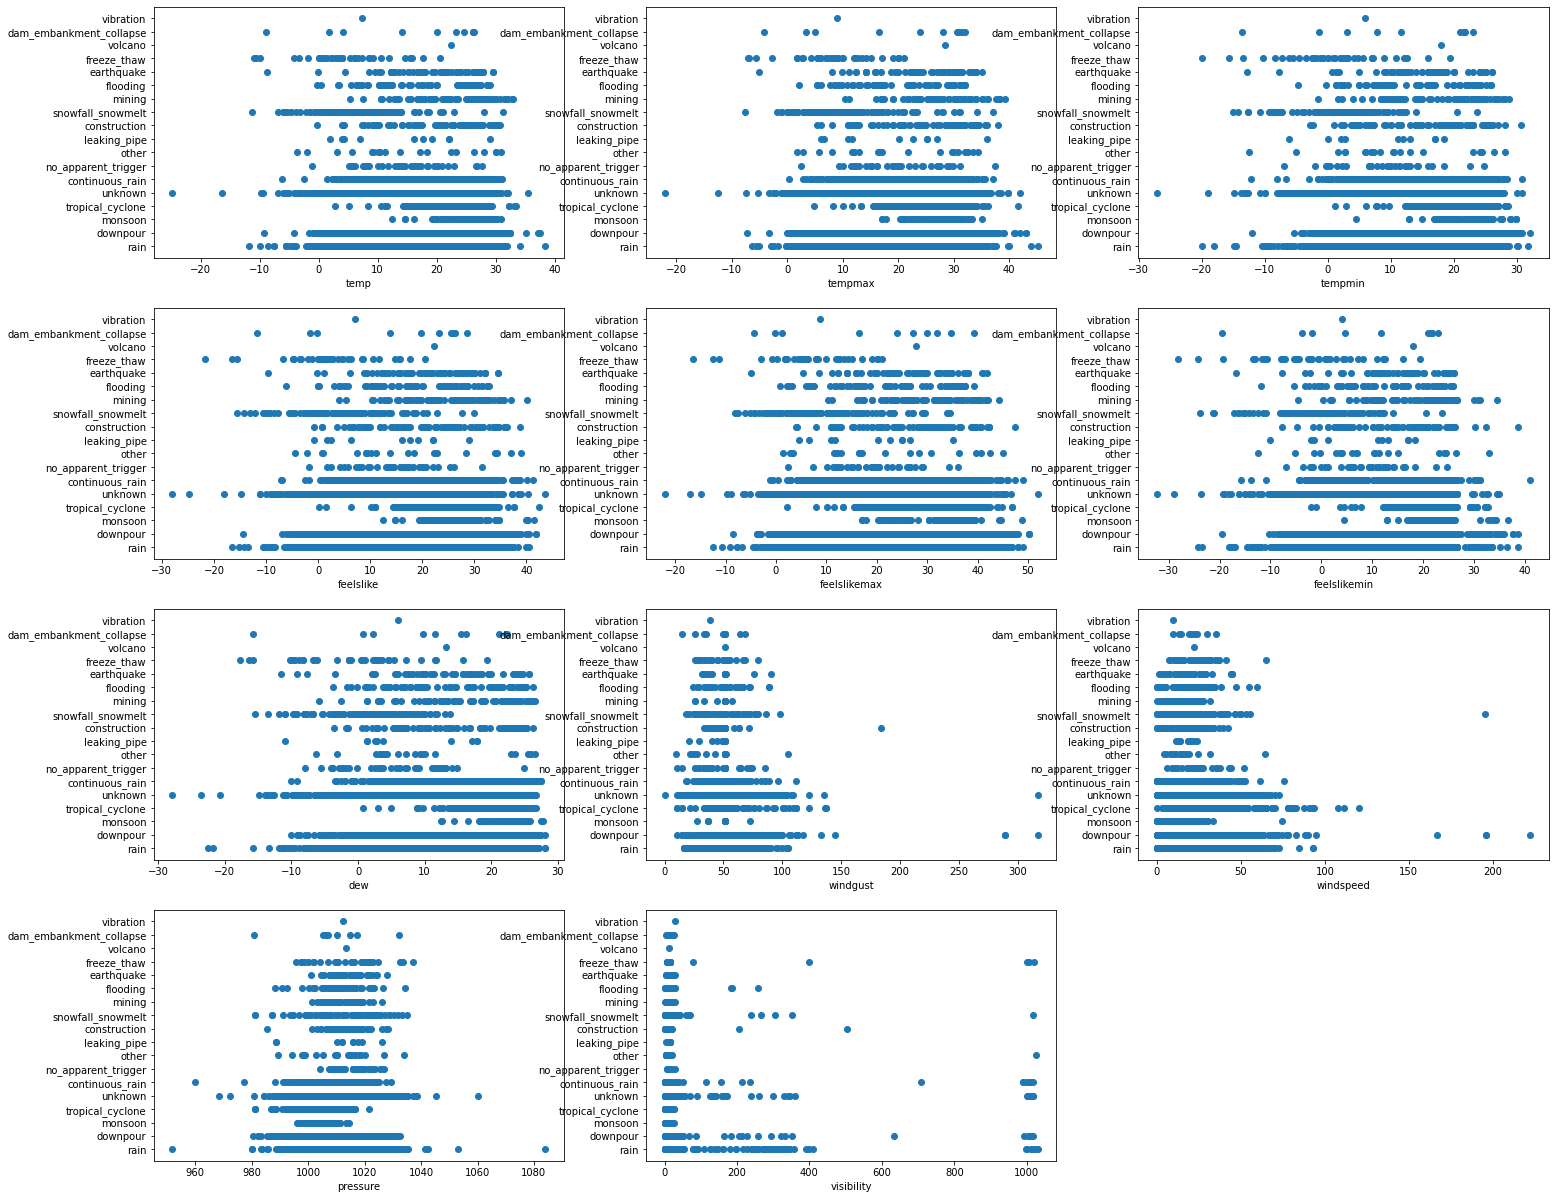

In [72]:
# before 
# (landslide_trigger)
fig = plt.figure(figsize=(25,60))
for i in range(len(outlier_col)):
    ax = plt.subplot(11,3, i+1)
    ax.scatter(df_preprocessed_missing[outlier_col[i]], df_preprocessed_missing['landslide_trigger'])
    ax.set_xlabel(outlier_col[i])

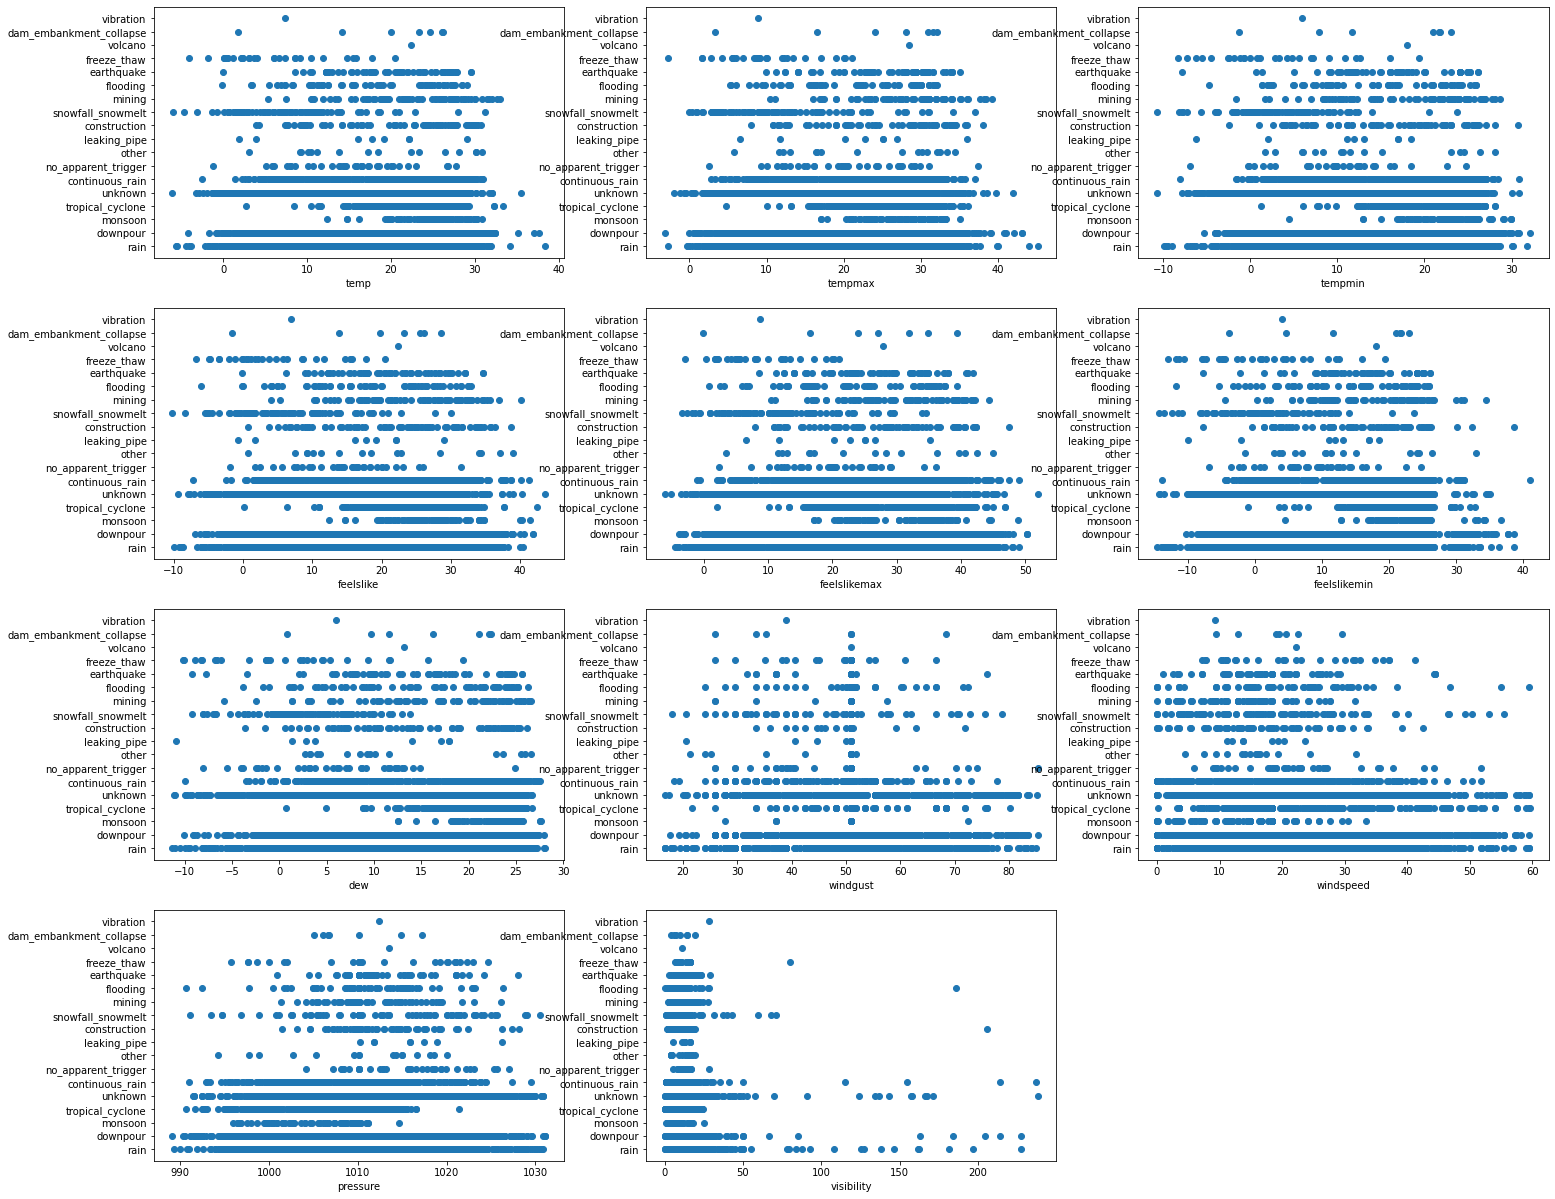

In [73]:
# after 
# (landslide_trigger)
fig = plt.figure(figsize=(25,60))
for i in range(len(outlier_col)):
    ax = plt.subplot(11,3, i+1)
    ax.scatter(df_preprocessed[outlier_col[i]], df_preprocessed['landslide_trigger'])
    ax.set_xlabel(outlier_col[i])

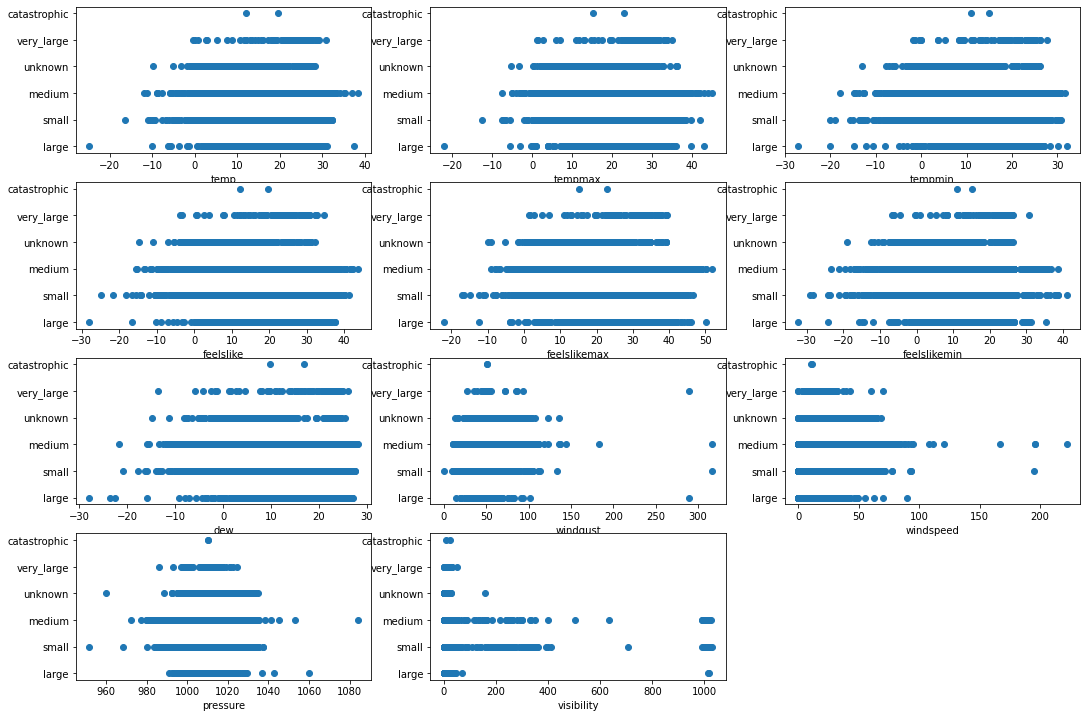

In [74]:
# before 
# (landslide_size)
fig = plt.figure(figsize=(18,35))
for i in range(len(outlier_col)):
    ax = plt.subplot(11,3, i+1)
    ax.scatter(df_preprocessed_missing[outlier_col[i]], df_preprocessed_missing['landslide_size'])
    ax.set_xlabel(outlier_col[i])

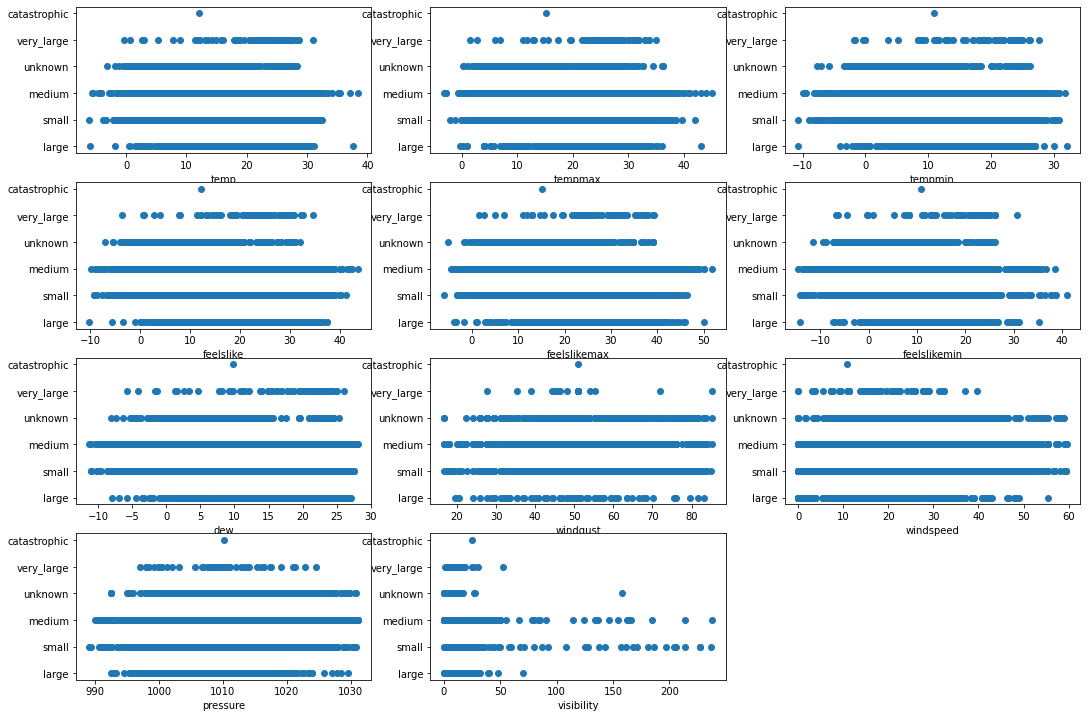

In [75]:
# after 
# (landslide_size)
fig = plt.figure(figsize=(18,35))
for i in range(len(outlier_col)):
    ax = plt.subplot(11,3, i+1)
    ax.scatter(df_preprocessed[outlier_col[i]], df_preprocessed['landslide_size'])
    ax.set_xlabel(outlier_col[i])

In [76]:
df_preprocessed.describe()

,fatality_count,injury_count,admin_division_population,gazeteer_distance,longitude,latitude,tempmax,tempmin,temp,feelslikemax,...,moonphase,elevation,treecover2000,loss,gain,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
count,8938.000000,8938.000000,8.938000e+03,8938.000000,8938.000000,8938.000000,8938.000000,8938.000000,8938.000000,8938.000000,...,8938.000000,8938.000000,8938.000000,8938.00000,8938.000000,8938.000000,8938.000000,8938.000000,8938.000000,8938.000000
mean,1.848624,0.260573,1.712863e+05,9.420518,-3.141650,25.683899,21.700951,15.098534,18.199765,23.062206,...,0.503241,641.511188,33.145223,0.03267,0.005258,1058.545171,1132.512488,1200.251353,1266.771969,1329.066473
std,12.961741,2.405379,8.448894e+05,13.208298,101.953596,20.520383,8.335628,8.343562,8.019160,10.563619,...,0.302824,761.663651,38.603613,0.17778,0.072328,3900.354448,4168.401590,4404.942304,4667.652369,4967.008183
min,0.000000,0.000000,0.000000e+00,0.000030,-179.980766,-46.774800,-3.200000,-10.700000,-6.100000,-6.100000,...,0.000000,-9.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.356000e+03,1.122923,-111.822025,13.389800,14.300000,8.300000,11.400000,14.300000,...,0.260000,79.000000,0.000000,0.00000,0.000000,18.789039,20.029362,20.911904,21.662651,22.083884
50%,0.000000,0.000000,1.005500e+04,4.404570,-2.492865,30.553200,23.900000,16.600000,20.100000,23.900000,...,0.500000,303.000000,9.000000,0.00000,0.000000,123.108559,131.045120,136.210052,137.400955,139.113647
75%,0.000000,0.000000,4.739925e+04,12.670153,94.048225,40.897950,28.600000,23.000000,25.300000,31.500000,...,0.760000,1004.000000,74.000000,0.00000,0.000000,577.450638,633.056580,659.666687,676.627960,691.472702
max,491.000000,100.000000,1.269184e+07,197.804230,179.399700,72.627500,45.100000,32.100000,38.400000,51.900000,...,1.000000,4994.000000,100.000000,1.00000,1.000000,110884.898438,116474.906250,121829.195312,126877.765625,130805.859375


In [77]:
df_preprocessed_missing.describe()

,fatality_count,injury_count,admin_division_population,gazeteer_distance,longitude,latitude,tempmax,tempmin,temp,feelslikemax,...,moonphase,elevation,treecover2000,loss,gain,population_density_2000,population_density_2005,population_density_2010,population_density_2015,population_density_2020
count,9345.000000,9345.000000,9.345000e+03,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,...,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000,9345.000000
mean,2.103799,0.329909,1.679575e+05,9.426601,-4.920161,26.215667,21.333494,14.729941,17.835152,22.613740,...,0.505231,638.809203,33.246228,0.032959,0.005350,1034.169044,1105.783287,1171.478656,1235.838730,1296.036963
std,23.075209,5.681036,8.351926e+05,13.409209,101.916202,20.648753,8.561733,8.593517,8.261297,10.799578,...,0.303006,759.750330,38.648739,0.178538,0.072955,3824.882716,4087.305679,4318.986475,4576.066767,4868.780250
min,0.000000,0.000000,0.000000e+00,0.000030,-179.980766,-46.774800,-22.100000,-27.100000,-24.800000,-22.100000,...,0.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.344000e+03,1.111150,-115.370300,13.979100,13.800000,7.800000,10.900000,13.800000,...,0.260000,78.000000,0.000000,0.000000,0.000000,17.617085,18.637699,19.280121,20.263063,20.385517
50%,0.000000,0.000000,9.813000e+03,4.402630,-4.257100,31.724154,23.600000,16.100000,19.700000,23.600000,...,0.500000,303.000000,9.000000,0.000000,0.000000,118.634872,125.784706,131.081116,132.363754,134.585480
75%,0.000000,0.000000,4.642700e+04,12.592160,93.688400,41.994400,28.400000,23.000000,25.200000,31.300000,...,0.760000,998.000000,74.000000,0.000000,0.000000,571.506165,621.184937,644.066467,665.461731,677.256897
max,1765.000000,374.000000,1.269184e+07,197.804230,179.399700,72.627500,45.100000,32.100000,38.400000,51.900000,...,1.000000,4994.000000,100.000000,1.000000,1.000000,110884.898438,116474.906250,121829.195312,126877.765625,130805.859375


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a4b21f1-38a8-48df-b58c-e4024e3ad583' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>